# Notebook Purpose

# Import Dependencies

Dependencies will also compile special loss functions (CUDA implemented Earth Mover's Distance) which is in the `emd/structured_losses` directory.

In [1]:
import numpy as np
from pointcloud_helpers import *

import keras
from keras.losses import MSE
from keras.layers import Lambda, Input, Dense, Conv1D, Conv2D, MaxPooling1D, BatchNormalization, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dropout
from keras.models import Model, Sequential,load_model
from keras import callbacks
from keras import backend as K
import pandas as pd
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.clear_session()

Done compiling CUDA scripts


Using TensorFlow backend.


In [2]:
semantic_net = load_model("../data/chair_net_150.h5", custom_objects={ 'emd': emd})
semantic_df = pd.read_csv("../data/semantic-data.csv")
chair_ptclouds_ids = np.load("../data/chair_ptclouds_ids.npz", allow_pickle=True)["arr_0"]

In [3]:
decoder = semantic_net.layers[-1].layers[-1]
encoder = semantic_net.layers[-1].layers[-2]

# Check model outputs qualitatively

Note that there are 6 dimensions that can be altered. They map to the semantic parameters in this order:  torso_length, neck_length, neck_rotation, leg_length, tail_length, tail_rotation. As all parameters were normalized prior to training, any value between 0-1 is valid.

from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from flask import Flask, send_file, request, jsonify, g
from werkzeug.exceptions import BadRequest
from werkzeug.utils import secure_filename

app = Flask(__name__)
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    values = request.form["values"].split('|')
    
    #split the parameter values into something
    values = np.array([float(val) for val in values])
    random_decoded = decoder.predict(values.reshape(1,1,1,23)).reshape(6144)
    
    xyz_string = ",".join([str(pt) for pt in random_decoded.tolist()])

    #return 12 nearest neighbors
    return jsonify(xyz_string)

def run():
    app.run(host='0.0.0.0',port=5000, threaded=False)


In [4]:
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from flask import Flask, send_file, request, jsonify, g
from werkzeug.exceptions import BadRequest
from werkzeug.utils import secure_filename


In [5]:

def run():
    app.run(host='0.0.0.0',port=5000, threaded=False)


In [6]:
import random
import pandas as pd

In [7]:
chair_ptclouds = chair_ptclouds_ids[0]
chair_ids = chair_ptclouds_ids[1]


# Suggested Queries

In [8]:
# shapeglot_condensed = pd.DataFrame(semantic_df["shapeglot"].str.cat(sep=" ").split(" "), columns=["words"])
# shapeglot_counts = shapeglot_condensed.groupby("words").agg("size").sort_values(ascending=False)
# suggested_queries = shapeglot_counts[:5]

In [9]:
chair_dict = {}
for chair_id, ptcloud in zip(chair_ids, chair_ptclouds):
    chair_dict[chair_id.split("_")[1]] = ptcloud

# Find Matches

In [10]:
def find_match(dataset,dataframe, search_query, num_matches, dataframe_col="search_query"):
    if dataset=="all":
        return find_match_bag_of_words(dataframe, search_query, num_matches, dataframe_col="search_query" )
    else:
        return find_match_shapeglot(dataframe,search_query, num_matches, dataframe_col="search_query" )

In [11]:
def find_match_bag_of_words(dataframe, search_query, num_matches, dataframe_col="search_query"):
    hits =dataframe["bag_of_words"].str.find(search_query)
    
    hits = dataframe["name"].where(hits > -1).dropna().index
    
    
    set_of_hits = [int(hits.values[i]) for i in range(min(len(hits), num_matches)) ] 
    
    print(dataframe.iloc[set_of_hits]["bag_of_words"])
    result_pointclouds = [chair_dict[i] for i in dataframe.iloc[set_of_hits]["name"]] 
    related_words = dataframe.iloc[dataframe.iloc[set_of_hits]["name"].index]["bag_of_words"].str.cat(sep =",")
#     related_words = ",".join(related_words.split(" ")[:4])
    
    return result_pointclouds, related_words

In [12]:
def find_match_shapeglot(dataframe, search_query, num_matches, dataframe_col="search_query"):
    hits =dataframe["shapeglot"].str.find(search_query)
    
    hits = dataframe["name"].where(hits > -1).dropna().index
    
    
    set_of_hits = [int(hits.values[i]) for i in range(min(len(hits), num_matches)) ] 
    
    print(dataframe.iloc[set_of_hits]["shapeglot"])
    result_pointclouds = [chair_dict[i] for i in dataframe.iloc[set_of_hits]["name"]] 
    related_words = dataframe.iloc[dataframe.iloc[set_of_hits]["name"].index]["shapeglot"].str.cat(sep =",")
#     related_words = ",".join(related_words.split(" ")[:4])
    
    return result_pointclouds, related_words

In [13]:
hits = semantic_df["shapeglot"].str.find("weird")
hits = semantic_df["name"].where(hits > -1).dropna().index

In [14]:
set_of_hits = [int(hits.values[i]) for i in range(min(len(hits), 3)) ] 
[chair_dict[i] for i in semantic_df.iloc[set_of_hits]["name"]]
related_words = semantic_df.iloc[semantic_df.iloc[set_of_hits]["name"].index]["shapeglot"].str.cat(sep =",")

In [15]:
related_words

'possible weird bucket shaped chair,looks weird highchair,pillow weird looking round circular seat'

In [16]:
related_words = find_match("all", semantic_df, "weird",3)[1]
related_words.split(" ")[:4]

10    hilarious witty laughable laugh joke guy goofy...
20    house curtains tattoos fancy pretty appealing ...
50    monkey weird strange music smell sad bored sle...
Name: bag_of_words, dtype: object


['hilarious', 'witty', 'laughable', 'laugh']

In [17]:
encoded_training_data = encoder.predict(chair_ptclouds.reshape(chair_ptclouds.shape[0], 2048,1,3))

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
import sklearn
from sklearn import manifold

ptclouds_tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5)

<Figure size 432x288 with 0 Axes>

In [19]:
# with open("ptclouds_tsne_3d.pkl", "wb") as f:
#     pickle.dump(ptclouds_tsne,f)

In [19]:
tsne_training_data = ptclouds_tsne.fit_transform(encoded_training_data.reshape(6778,128))




KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

X = tsne_training_data
kmeans = KMeans(n_clusters=12, random_state=0).fit(X)
kmeans.labels_

In [ ]:
cluster_colors = kmeans.predict(X)

In [20]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
color_palette = sns.color_palette("husl", 12)

plt.scatter(tsne_training_data[:,0], tsne_training_data[:,1], c=cluster_colors)
cluster_colors = np.array([color_palette[cluster_index] for cluster_index in cluster_colors]).flatten()

NameError: name 'tsne_training_data' is not defined

In [ ]:
tsne_training_data = np.array([[x,y,0] for x,y in tsne_training_data]).flatten()

In [ ]:
def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False, marker='.', s=8, alpha=.8, figsize=(5, 5), elev=10, azim=240, axis=None, title=None, *args, **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')        
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])  # Multiply with 0.7 to squeeze free-space.
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

In [ ]:
# plot_3d_point_cloud(tsne_training_data[:,0], tsne_training_data[:,1], tsne_training_data[:,2], c=cluster_colors)

In [ ]:
plot_3d_point_cloud(embedding[:,0], embedding[:,1], embedding[:,2], c =umap_colors)

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(n_components=3,random_state=42)
embedding = reducer.fit_transform(encoded_training_data.reshape(6778,128))
embedding = np.pad(embedding,(1,0),mode='constant') * 2
# umap_colors = kmeans.predict(embedding)
# umap_colors.flatten()

# Flask

In [ ]:
app = Flask(__name__)
encoded_base = None
# pcd = o3d.geometry.PointCloud()
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    global cluster_colors
#     search_hits, related_words = find_match("shapeglot", semantic_df, search_query, 4)
    
    encoder = semantic_net.layers[-1].layers[-2]
    decoder = semantic_net.layers[-1].layers[-1]
    
    num_results = 0
    related_words = ""
#     pointcloud_hits = [encoder.predict(result_pointcloud.reshape(1,2048,1,3)) for result_pointcloud in search_hits]
#     num_results = len(pointcloud_hits)
#     encoded_base = pointcloud_hits[0]
#     pointcloud_hits = np.array([decoder.predict(pointcloud) for pointcloud in pointcloud_hits]).flatten()
    
    tsne_map = tsne_training_data.flatten()
    
    
    xyz_string = ",".join([str(pt) for pt in tsne_map])
    color_string = ",".join([str(pt) for pt in  cluster_colors])
    
    
#     some dictionary
# return jsonify({some dictionary})
    
    return jsonify({'num_results':num_results, 'points_positions': xyz_string, "related_words" :related_words, "cluster_colors" : color_string})
    

In [ ]:
@app.route('/edit', methods=["POST"])
def edit_base():
#     global encoded_base
    edit_dimension = int(request.form["dimension_to_edit"])
    edit_magnitude = float(request.form["edit_magnitude"])
    
    encoded_base[0,0,0][edit_dimension] += edit_magnitude
    pointcloud = np.array(decoder.predict(encoded_base) ).flatten()
    xyz_string = ",".join([str(pt) for pt in pointcloud])

    return jsonify(xyz_string)

In [ ]:
# @app.route('/hover', methods=["POST"])
# def hover():
#     point_index = request.form["point_index"].encode('utf8')
    
    
#     pointcloud = decoder.predict(encoded_shapeglot[point_index]).flatten()
    
    

#     xyz_string = ",".join([str(pt) for pt in pointcloud])

#     related_words=""
    
# #     descriptors = list(semantic_df["shapeglot"]
#     descriptors = list(semantic_df.iloc[labeled_ids[point_index]]["shapeglot"])
#     if len(descriptors):

#         related_words =" ".join(descriptors)
#         print(related_words)
        
#     num_results = 0
    

#     return jsonify({'points_positions': xyz_string, "related_words": related_words, 'num_results':num_results})




In [ ]:
run()

In [96]:
chair_ids = chair_ptclouds_ids[1]
chair_ids =[name.split("_")[1] for name in chair_ids]

In [23]:
semantic_df.iloc[np.array(labeled_pts)]

NameError: name 'labeled_pts' is not defined

In [105]:
[id_index if name in chair_ids else -1 for id_index, name in zip(semantic_df["name"].index, semantic_df["name"] )]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [24]:
# labeled_ids = [id_index if name in  else chair_ids for id_index, name in zip(semantic_df["name"].index, semantic_df["name"] )]

In [125]:
len(labeled_ptclouds)

837

In [123]:
labeled_ptclouds = [ptcloud for index, ptcloud in zip(range(len(chair_ptclouds)), chair_ptclouds) if index in labeled_ids ]

In [126]:
labeled_ptclouds = [ptcloud for index, ptcloud in zip(range(len(chair_ptclouds)), chair_ptclouds) if index in labeled_ids ]
encoded_shapeglot = encoder.predict(np.array(labeled_ptclouds).reshape(837, 2048,1,3))

In [128]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(n_components=2,random_state=42)
embedding = reducer.fit_transform(encoded_shapeglot.reshape(837,128))


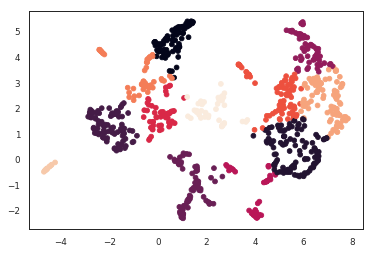

In [130]:
from sklearn.cluster import KMeans
import numpy as np
embedding = np.array([[x,y,0] for x,y in  embedding])

X = embedding
kmeans = KMeans(n_clusters=12, random_state=0).fit(X)
kmeans.labels_
umap_colors = kmeans.predict(embedding)
umap_colors.flatten()
plt.scatter(embedding[:,0], embedding[:,1], c =umap_colors)

In [1]:
app = Flask(__name__)
encoded_base = None
# pcd = o3d.geometry.PointCloud()
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    global cluster_colors
#     search_hits, related_words = find_match("shapeglot", semantic_df, search_query, 4)
    
    encoder = semantic_net.layers[-1].layers[-2]
    decoder = semantic_net.layers[-1].layers[-1]
    
    num_results = 0
    related_words = ""
#     pointcloud_hits = [encoder.predict(result_pointcloud.reshape(1,2048,1,3)) for result_pointcloud in search_hits]
#     num_results = len(pointcloud_hits)
#     encoded_base = pointcloud_hits[0]
#     pointcloud_hits = np.array([decoder.predict(pointcloud) for pointcloud in pointcloud_hits]).flatten()
    
    tsne_map = embedding.flatten()
    
    
    xyz_string = ",".join([str(pt) for pt in tsne_map])
    color_string = ",".join([str(pt) for pt in  cluster_colors])
    
    return jsonify({'num_results':num_results, 'points_positions': xyz_string, "related_words" :related_words, "search_reasons":"", "cluster_colors" : color_string, "swow_words":""})

@app.route('/hover', methods=["POST"])
def hover():
    point_index = int(request.form["point_index"].encode('utf8'))
    
    
    pointcloud = decoder.predict(np.expand_dims(encoded_shapeglot[point_index],0)).flatten()
    
    

    xyz_string = ",".join([str(pt) for pt in pointcloud])

    related_words=""
    
#     descriptors = list(semantic_df["shapeglot"]
    descriptors = list(semantic_df.iloc[labeled_ids[point_index]]["shapeglot"])
    
    swow_words = list(semantic_df.iloc[labeled_ids[point_index]]["swow"])
    wordnet_words = list(semantic_df.iloc[labeled_ids[point_index]]["wordnet"])
    
    if len(swow_words):
        swow_words = "".join(swow_words)

        
    if len(wordnet_words):
        wordnet_words = "".join(wordnet_words)

        
        
        
    if len(descriptors):

        related_words ="".join(descriptors)
      
        
    num_results = 0
    

    return jsonify({'points_positions': xyz_string, "related_words": related_words, 'num_results':num_results, "swow_words": swow_words, "search_reasons":"", "wordnet_words": wordnet_words})



@app.route('/search', methods=["POST"])
def search():
    search_query = request.form["search_query"].encode('utf8')
    search_hits, related_words = find_match("shapeglot", semantic_df, search_query, 4)
    
    encoder = semantic_net.layers[-1].layers[-2]
    decoder = semantic_net.layers[-1].layers[-1]
    
    pointcloud_hits = [encoder.predict(result_pointcloud.reshape(1,2048,1,3)) for result_pointcloud in search_hits]
    num_results = len(pointcloud_hits)
    encoded_base = pointcloud_hits[0]
    pointcloud_hits = np.array([decoder.predict(pointcloud) for pointcloud in pointcloud_hits]).flatten()
    
    xyz_string = ",".join([str(pt) for pt in pointcloud_hits])

    return jsonify({'num_results':num_results, 'points_positions': xyz_string, 'search_reasons': related_words})
    

NameError: name 'Flask' is not defined

In [136]:
run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
[2021-06-14 15:46:59,092] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-133-20fa19f48c33>", line 15, 

172.17.0.1 - - [14/Jun/2021 15:46:59] "POST /hover HTTP/1.1" 500 -
[2021-06-14 15:46:59,150] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-133-20fa19f48c33>", 

172.17.0.1 - - [14/Jun/2021 15:46:59] "POST /hover HTTP/1.1" 500 -
[2021-06-14 15:46:59,622] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-133-20fa19f48c33>", 

172.17.0.1 - - [14/Jun/2021 15:46:59] "POST /hover HTTP/1.1" 500 -
[2021-06-14 15:46:59,717] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-133-20fa19f48c33>", 

172.17.0.1 - - [14/Jun/2021 15:46:59] "POST /hover HTTP/1.1" 500 -
[2021-06-14 15:46:59,883] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-133-20fa19f48c33>", 

172.17.0.1 - - [14/Jun/2021 15:46:59] "POST /hover HTTP/1.1" 500 -
[2021-06-14 15:46:59,942] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-133-20fa19f48c33>", 

172.17.0.1 - - [14/Jun/2021 15:47:00] "POST /hover HTTP/1.1" 500 -
[2021-06-14 15:47:00,233] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-133-20fa19f48c33>", 

172.17.0.1 - - [14/Jun/2021 15:47:00] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 15:47:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 15:47:00] "POST /hover HTTP/1.1" 200 -
[2021-06-14 16:13:15,817] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", lin

172.17.0.1 - - [14/Jun/2021 16:13:16] "POST /hover HTTP/1.1" 500 -
[2021-06-14 16:13:16,336] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-133-20fa19f48c33>", 

In [143]:
decoder.predict(np.expand_dims(encoded_shapeglot[0],0)).flatten()

array([ 0.24561957, -0.08923101, -0.24115528, ...,  0.12975128,
        0.24985053,  0.07901674], dtype=float32)

In [205]:
!git commit -a -m "implemented search and map"

[master 155aaee] implemented search and map
 1 file changed, 1906 insertions(+), 5242 deletions(-)
 rewrite training_scripts/Generative_Semantic_Map.ipynb (81%)


In [60]:
for i in range(len(chair_ptclouds_ids[1])):
    if chair_ptclouds_ids[1][i] == "03001627_86b6e539e72be6d46fa0ab61d9f9d96d":
        print(i)

3413


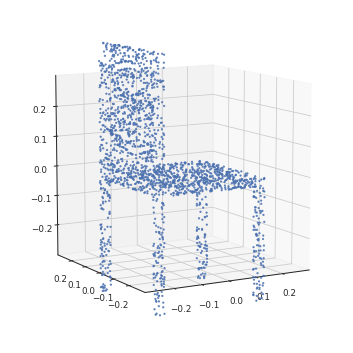

In [62]:
plot_ptcloud(chair_ptclouds_ids[0][3413])

In [73]:
umap_embedding = zip(encoded_shapeglot,embedding)[0][1]

In [137]:
labeled_ptclouds

[array([[ 0.1463568 , -0.14350623, -0.416705  ],
        [ 0.13256958, -0.13636376, -0.416705  ],
        [-0.10411606,  0.12250885, -0.416705  ],
        ...,
        [-0.16927277, -0.10955272,  0.41667837],
        [-0.15986188, -0.13388985,  0.4166814 ],
        [-0.16067883, -0.11606838,  0.416705  ]], dtype=float32),
 array([[ 0.20183186, -0.17528607, -0.412546  ],
        [-0.17413127, -0.18128754, -0.41254508],
        [-0.17809689,  0.17612654, -0.41251865],
        ...,
        [-0.1992369 , -0.05253345,  0.412546  ],
        [-0.19620255,  0.01291505,  0.412546  ],
        [-0.17765076,  0.16592757,  0.412546  ]], dtype=float32),
 array([[-0.14629681, -0.07814202, -0.44144595],
        [ 0.16081944,  0.16313991, -0.44045213],
        [ 0.15413176,  0.1494591 , -0.4399882 ],
        ...,
        [-0.14302543,  0.05768158,  0.4411843 ],
        [-0.14324492,  0.03795515,  0.44122288],
        [-0.14455123, -0.06818054,  0.44144595]], dtype=float32),
 array([[ 0.15417463,  0.136

In [141]:
len(labeled_ptclouds)

837

In [82]:
# create a dataframe of umap colors
zip(range(len(umap_colors)), umap_colors)

[(0, 4),
 (1, 3),
 (2, 1),
 (3, 11),
 (4, 10),
 (5, 11),
 (6, 1),
 (7, 5),
 (8, 10),
 (9, 0),
 (10, 8),
 (11, 8),
 (12, 6),
 (13, 0),
 (14, 3),
 (15, 3),
 (16, 0),
 (17, 7),
 (18, 1),
 (19, 0),
 (20, 2),
 (21, 5),
 (22, 3),
 (23, 1),
 (24, 7),
 (25, 1),
 (26, 2),
 (27, 9),
 (28, 2),
 (29, 0),
 (30, 6),
 (31, 11),
 (32, 0),
 (33, 2),
 (34, 1),
 (35, 11),
 (36, 5),
 (37, 2),
 (38, 7),
 (39, 0),
 (40, 5),
 (41, 4),
 (42, 11),
 (43, 10),
 (44, 0),
 (45, 3),
 (46, 7),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 5),
 (51, 3),
 (52, 0),
 (53, 7),
 (54, 0),
 (55, 3),
 (56, 4),
 (57, 10),
 (58, 5),
 (59, 6),
 (60, 7),
 (61, 7),
 (62, 0),
 (63, 3),
 (64, 3),
 (65, 0),
 (66, 6),
 (67, 2),
 (68, 11),
 (69, 5),
 (70, 6),
 (71, 11),
 (72, 1),
 (73, 6),
 (74, 5),
 (75, 7),
 (76, 6),
 (77, 3),
 (78, 2),
 (79, 10),
 (80, 10),
 (81, 7),
 (82, 10),
 (83, 5),
 (84, 2),
 (85, 4),
 (86, 4),
 (87, 0),
 (88, 3),
 (89, 4),
 (90, 1),
 (91, 7),
 (92, 11),
 (93, 7),
 (94, 5),
 (95, 1),
 (96, 4),
 (97, 4),
 (98, 0),
 (99,

In [149]:
def get_index(name):
    for chair_index, chair_name in zip(range(len(chair_ids)),chair_ids):
        if name==chair_name:
            return chair_index
labeled_indices = []
for name in semantic_df["name"]:
    labeled_indices.append(get_index(name))
    

In [150]:
labeled_ids = labeled_indices

In [159]:
labeled_ptclouds = []
for chair_id in labeled_ids:
    labeled_ptclouds.append(chair_ptclouds[chair_id])
labeled_ptclouds = np.array(labeled_ptclouds)

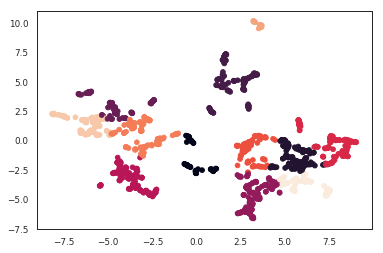

In [409]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
sns.set(context="paper", style="white")
color_palette = sns.color_palette("husl", 12)

encoded_shapeglot = encoder.predict(labeled_ptclouds.reshape(1343,2048,1,3))
reducer = umap.UMAP(n_components=2,random_state=42)
embedding = reducer.fit_transform(encoded_shapeglot.reshape(1343,128))
embedding = np.array([[x,y,0] for x,y in  embedding])
X = embedding
kmeans = KMeans(n_clusters=12, random_state=0).fit(X)
kmeans.labels_
umap_colors = kmeans.predict(embedding)
umap_colors.flatten()
plt.scatter(embedding[:,0], embedding[:,1], c =umap_colors)

cluster_colors = np.array([color_palette[cluster_index] for cluster_index in umap_colors]).flatten()

In [410]:
app = Flask(__name__)
encoded_base = None
# pcd = o3d.geometry.PointCloud()
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    global cluster_colors
#     search_hits, related_words = find_match("shapeglot", semantic_df, search_query, 4)
    
    encoder = semantic_net.layers[-1].layers[-2]
    decoder = semantic_net.layers[-1].layers[-1]
    
    num_results = 0
    related_words = ""
#     pointcloud_hits = [encoder.predict(result_pointcloud.reshape(1,2048,1,3)) for result_pointcloud in search_hits]
#     num_results = len(pointcloud_hits)
#     encoded_base = pointcloud_hits[0]
#     pointcloud_hits = np.array([decoder.predict(pointcloud) for pointcloud in pointcloud_hits]).flatten()
    
    tsne_map = embedding.flatten()
    
    
    xyz_string = ",".join([str(pt) for pt in tsne_map])
    color_string = ",".join([str(pt) for pt in  cluster_colors])
    
    return jsonify({'num_results':num_results, 'points_positions': xyz_string, "related_words" :related_words, "search_reasons":"", "cluster_colors" : color_string, "swow_words":""})

@app.route('/hover', methods=["POST"])
def hover():
    point_index = int(request.form["point_index"].encode('utf8'))
    
    
    pointcloud = decoder.predict(np.expand_dims(encoded_shapeglot[point_index],0)).flatten()
    
    

    xyz_string = ",".join([str(pt) for pt in pointcloud])

    related_words=""
    
#     print(point_index)
#     print(labeled_ids[point_index])
#     
    database_row = point_index
#     print(database_row)
#     print("next")
#     descriptors = list(semantic_df["shapeglot"]
    descriptors = list(semantic_df.iloc[database_row]["shapeglot"])
    
    swow_words = list(semantic_df.iloc[database_row]["swow"])
    wordnet_words = list(semantic_df.iloc[database_row]["wordnet"])
    cluster_description = word_clusters[semantic_df.iloc[database_row]["colors"]]
    
    
    if len(swow_words):
        swow_words = "".join(swow_words)

        
    if len(wordnet_words):
        wordnet_words = "".join(wordnet_words)

        
        
        
    if len(descriptors):

        related_words ="".join(descriptors)
      
        
    num_results = 0
    
    return jsonify({'points_positions': xyz_string, "related_words": related_words, 'num_results':num_results, "swow_words": swow_words, "search_reasons":"", "wordnet_words": wordnet_words, "cluster_description":cluster_description})



@app.route('/search', methods=["POST"])
def search():
    search_query = request.form["search_query"].encode('utf8')
    search_hits, related_words = find_match("shapeglot", semantic_df, search_query, 4)
    
    encoder = semantic_net.layers[-1].layers[-2]
    decoder = semantic_net.layers[-1].layers[-1]
    
    pointcloud_hits = [encoder.predict(result_pointcloud.reshape(1,2048,1,3)) for result_pointcloud in search_hits]
    num_results = len(pointcloud_hits)
    encoded_base = pointcloud_hits[0]
    pointcloud_hits = np.array([decoder.predict(pointcloud) for pointcloud in pointcloud_hits]).flatten()
    
    xyz_string = ",".join([str(pt) for pt in pointcloud_hits])

    return jsonify({'num_results':num_results, 'points_positions': xyz_string, 'search_reasons': related_words})
    

In [411]:
run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
172.17.0.1 - - [14/Jun/2021 17:46:43] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:45] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:45] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:45] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:45] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:45] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:45] "POST /hover HTTP/1.1" 200 -
172.17.0.

172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 17:46:57] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 17:47:19] "POST /hover HTTP/1.1" 500 -
[2021-06-14 17:47:19,614] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

12                                  round hole
16                              round wide rim
33                                     rounded
93    rounded cushiony cupholders thinner arms
Name: shapeglot, dtype: object


172.17.0.1 - - [14/Jun/2021 17:49:02] "POST /search HTTP/1.1" 200 -


93    rounded cushiony cupholders thinner arms
Name: shapeglot, dtype: object


172.17.0.1 - - [14/Jun/2021 17:49:05] "POST /search HTTP/1.1" 200 -


93            rounded cushiony cupholders thinner arms
123                                 solid thinner legs
943                                        thinner gap
1322    vertical pieces thicker top piece thinner legs
Name: shapeglot, dtype: object


172.17.0.1 - - [14/Jun/2021 18:05:40] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:05:42] "POST /hover HTTP/1.1" 200 -


172.17.0.1 - - [14/Jun/2021 18:09:37] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:09:37,917] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

13           tall
19      tall slat
21    tall square
22    tall square
Name: shapeglot, dtype: object


172.17.0.1 - - [14/Jun/2021 18:10:22] "POST /search HTTP/1.1" 200 -


217                                high back slats
1071    high back arms semi - circle bottom shaped
1141                           high backrest lines
1167                                 high backrest
Name: shapeglot, dtype: object


172.17.0.1 - - [14/Jun/2021 18:10:25] "POST /search HTTP/1.1" 200 -


1071    high back arms semi - circle bottom shaped
1077                  semi - circle hole geometric
Name: shapeglot, dtype: object


172.17.0.1 - - [14/Jun/2021 18:10:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:30] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:10:32] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:32,504] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:32] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:32,601] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:32] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:32,699] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:32] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:32,793] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:35] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:10:36] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:36,264] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:36] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:36,359] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:36] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:36,460] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:36] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:36,556] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:36] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:36,650] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:39] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:10:39,356] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:10:44] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:40] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:11:43] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:43] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:44] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:46] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:11:48] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:53] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:53] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:53] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:53] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:11:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:59] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:11:59] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:03] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:12:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:12:06] "POST /hover HTTP/1.1" 200 -
[2021-06-14 18:12:07,974] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_d

[2021-06-14 18:12:08,064] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 48, in hover
    descriptors = list(semantic_df.iloc[database_

172.17.0.1 - - [14/Jun/2021 18:12:08] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:08,157] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:08] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:08,246] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:08] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:08,337] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:08] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:08,430] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:08] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:08,522] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:09] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:09,126] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:09] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:09,218] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:09] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:09,310] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:09] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:09,402] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:09] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:09,493] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:09] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:09,585] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:12:10] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:12:10,166] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:14:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:06] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:14:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:10] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:10] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:10] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:11] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:17:22] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:22] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:22] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:27] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:17:31] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:04] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:18:07,673] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:18:07,763] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:18:07,856] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:18:07] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:18:07,946] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:18:08,038] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:08] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:17] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:19] "POST /hover HTTP/1.1" 2

[2021-06-14 18:18:34,136] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 50, in hover
    swow_words = list(semantic_df.iloc[database_r

172.17.0.1 - - [14/Jun/2021 18:18:34] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:18:34,229] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:18:34] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:18:34,322] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:18:34] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:18:34,415] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

[2021-06-14 18:18:34,550] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 48, in hover
    descriptors = list(semantic_df.iloc[database_

172.17.0.1 - - [14/Jun/2021 18:18:43] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:18:44] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:19:17] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:19:17,365] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:19:21] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:19:21,334] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:19:22] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:19:22,203] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:19:22] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:19:22,296] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:19:22] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:19:22,386] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:29] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:19:33,097] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:33] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:19:37] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 18:19:37] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:37] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:37] "POST /hover HTTP/1.1" 200 -
[2021-06-14 18:19:37,728] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anac

172.17.0.1 - - [14/Jun/2021 18:19:38] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:19:38,312] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:19:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:19:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:11] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:22:15] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:22:15,926] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:19] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:22:21] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:22:21,108] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:22:21] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:22:21,202] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:28] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:22:40] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:43] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:43] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:43] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:22:43] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:22:57] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:22:57,126] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:23:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:04] "POST /hover HTTP/1.1" 200 -
[2021-06-14 18:23:04,992] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/roo

172.17.0.1 - - [14/Jun/2021 18:23:06] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:23:06,825] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:23:10] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:10] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:11] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:12] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:12] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:12] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:12] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:23:20] "POST /hover HTTP/1.1" 500 -
[2021-06-14 18:23:20,805] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 18:23:31] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 18:23:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:32] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:23:38] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:38] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:38] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:38] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:38] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:38] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:39] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:40] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:23:43] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 18:23:43] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:43] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:44] "POST /hover HTTP/1.1" 200 -
[2021-06-14 18:23:44,664] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/env

172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:23:58] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 18:29:03] "POST /hover HTTP/1.1" 200 -
[2021-06-14 18:29:03,420] ERROR in app: Exception on /hover [P

172.17.0.1 - - [14/Jun/2021 20:07:34] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:34] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:34] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:07:54] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 20:08:00] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:08:00,671] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 20:08:00] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:08:00,763] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 20:08:00] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:08:00,857] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 20:08:00] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:08:00,948] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:08:01,038] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:08:01,134] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

[2021-06-14 20:08:01,416] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 50, in hover
    swow_words = list(semantic_df.iloc[database_r

172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:01] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 20:08:03] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:08:03,128] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 20:08:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:08:04] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:09:31] "POST /search HTTP/1.1" 200 -


87      dark squarish thick legs
107    thick legs thin slats top
113      square solid thick legs
181                   thick slat
Name: shapeglot, dtype: object


172.17.0.1 - - [14/Jun/2021 20:09:38] "POST /search HTTP/1.1" 200 -


4                    office chair
56                   office chair
173    padded square office chair
183                 office wheels
Name: shapeglot, dtype: object


172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:10:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:11:47] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:11:47] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:11:47] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:11:48] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 20:12:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:32] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:33] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 20:12:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:35] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:36] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:36] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:36] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:36] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:36] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:36] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:36] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:36] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:42] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:52] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 20:12:59] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:59] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:59] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:59] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:12:59] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:13:05] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 20:13:07] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:13:07,418] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 20:13:07] "POST /hover HTTP/1.1" 500 -
[2021-06-14 20:13:07,513] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 20:16:31] "POST /search HTTP/1.1" 500 -


Series([], Name: shapeglot, dtype: object)


[2021-06-14 20:16:35,496] ERROR in app: Exception on /search [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 86, in search
    encoded_base = pointcloud_hits[0]
IndexErro

Series([], Name: shapeglot, dtype: object)


172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 20:19:00] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:03] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:15] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 21:52:21] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:21] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:21] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:21] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:21] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:21] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:21] "POST /hover HTTP/1.1" 200 -
[2021-06-14 21:52:27,414] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    r

172.17.0.1 - - [14/Jun/2021 21:52:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:40] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:52:41] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 21:53:55] "POST /search HTTP/1.1" 500 -


Series([], Name: shapeglot, dtype: object)


[2021-06-14 21:54:15,148] ERROR in app: Exception on /search [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 86, in search
    encoded_base = pointcloud_hits[0]
IndexErro

Series([], Name: shapeglot, dtype: object)


172.17.0.1 - - [14/Jun/2021 21:54:21] "POST /search HTTP/1.1" 200 -


10             funny short arms
17                    open arms
18    solid chair skinnier arms
23                  curved arms
Name: shapeglot, dtype: object


[2021-06-14 21:54:40,170] ERROR in app: Exception on /search [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 86, in search
    encoded_base = pointcloud_hits[0]
IndexErro

Series([], Name: shapeglot, dtype: object)


[2021-06-14 21:54:47,973] ERROR in app: Exception on /search [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 86, in search
    encoded_base = pointcloud_hits[0]
IndexErro

Series([], Name: shapeglot, dtype: object)


[2021-06-14 21:54:50,248] ERROR in app: Exception on /search [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", line 86, in search
    encoded_base = pointcloud_hits[0]
IndexErro

Series([], Name: shapeglot, dtype: object)


172.17.0.1 - - [14/Jun/2021 21:55:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:55] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:56] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 21:55:56] "POST /hover HTTP/1.1" 2

172.17.0.1 - - [14/Jun/2021 22:13:25] "POST /hover HTTP/1.1" 500 -
[2021-06-14 22:13:25,833] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 22:13:25] "POST /hover HTTP/1.1" 500 -
[2021-06-14 22:13:25,928] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 22:13:26] "POST /hover HTTP/1.1" 500 -
[2021-06-14 22:13:26,777] ERROR in app: Exception on /hover [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds/lib/python2.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-410-4fb3cdedc237>", 

172.17.0.1 - - [14/Jun/2021 22:13:26] "POST /hover HTTP/1.1" 500 -
172.17.0.1 - - [14/Jun/2021 22:13:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:13:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:13:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:13:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:13:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:13:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:13:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:13:31] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:16:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:16:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:16:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:16:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:16:07] "POST /hover HTTP/1.1" 200 -
172.17.0.1 - - [14/Jun/2021 22:16:07] "POST /hover HTTP/1.1" 2

In [184]:
indexing_shapeglot = zip(range(len(labeled_ids)),labeled_ids)

In [212]:
semantic_df["colors"] = umap_colors

In [303]:
cluster_words = semantic_df.groupby("colors")["shapeglot"].agg(list)

In [310]:
word_clusters = {}
for cluster in range(len(cluster_words)):
    join_word_cluster = ""
    for word in cluster_words[cluster]:
        join_word_cluster += str(word) + " "
    word_clusters[cluster] = join_word_cluster


In [312]:
cluster_words[0]

['openings',
 'tall square',
 'long legs short seat',
 'short arms smaller section top',
 'funky curved arms openings',
 'cushiony thin legs',
 'thinnest legs',
 'slats holes',
 'leg bars thin',
 'solid piece',
 'flat blocky',
 'biggest',
 'flat space',
 'flat pattern legs thin',
 'deck chair',
 'high legs',
 'solid square',
 'clicking',
 'lol narrows means gets wider',
 'thought square strap attach head chair part',
 'good',
 nan,
 'bunch holes',
 'called slats lol',
 'slats',
 'slats',
 'chair plain crossbars bottom thinnest cushion chairs looks layers',
 'chair plain textured highest chairs',
 'shair looks cushion armrests flat square seat',
 'rounded slats armrests',
 'low chair thin legs',
 'chair legs',
 'curves',
 'bench looking gap middle',
 'lawn chair',
 'solid',
 'legs saggy bottom',
 'tall multiple piece',
 'cloth folding',
 'legs',
 nan,
 nan,
 'fattest legs',
 'see rows slats',
 'metal visible cloth back square triangle',
 'vertical holes',
 'chair cup holders',
 'armless

In [313]:
word_clusters[0]

"openings tall square long legs short seat short arms smaller section top funky curved arms openings cushiony thin legs thinnest legs slats holes leg bars thin solid piece flat blocky biggest flat space flat pattern legs thin deck chair high legs solid square clicking lol narrows means gets wider thought square strap attach head chair part good nan bunch holes called slats lol slats slats chair plain crossbars bottom thinnest cushion chairs looks layers chair plain textured highest chairs shair looks cushion armrests flat square seat rounded slats armrests low chair thin legs chair legs curves bench looking gap middle lawn chair solid legs saggy bottom tall multiple piece cloth folding legs nan nan fattest legs see rows slats metal visible cloth back square triangle vertical holes chair cup holders armless slatted back chair angular solid top opening shallow front legs nan chunky slits arm rests legs look 's poles called side arches seat curved lumbar area short normal directors chair 

In [314]:
word_clusters[1]

'tombstone shape kitchen chair tall spindles slat back slats similar space seat fancy back slats scrolls slats openings slats openings squared slim tallest holes slats nan nan legs tall hole nan tall thin seat thick slat slatted large flat black slat rounded seat padded square flat vertical many slats flat square fancy high back slats vertical slats slats small slats top squarish solid high opening many slats many slats thickest looking supports small squares top high rectangular cutout wider slats middle virticle slats square shape holes chair holes curvy base looks peice bread backrest raised oval see top hard chair bars tallest chair plainest chair complicated chair looks cheese grater hole chair holes wood legs bars middle bars hole arms holes long chair alot bars chair wider others bars small gap piece left seat flat tall chair whole top big slat poles round seat tall thin legs solid legs see back point fenced vertical fencing fence beams closest thicker thick back solid piece loo

In [322]:
word_clusters[2]

'office chair round wide rim tall rectangle joined seat small wheels wheels curved tall little handle side arms office chair similar circle base nan arms wheeled legs wheeled legs desk chair seat circle holes office wheels foot rest odd shape office square padded individual legs circular shape solid thick arm rests rolling office chair rolling square square straight lines folded office chair wide seat head cushion long metal legs folded supports showing office chair rectangular circular looking chair one arm rest misclick sorry nan oval shape head seat strangest alien chair solid hole narrows goes square rectangle strap rectangle problem chair rectangle curved taller straighter chairs solid base looks cube backrest curved corners top chair sections shortest chair circle top nan chair standing chicken leg square block chair circle top cut hand chair chair hole roundest chair chair ears smooth chair big legs thickest base rolling nan office chair chair handle bottom left raised leg round

In [323]:
word_clusters[3]

'curved seat shorter length short chair slats rounded cushiony cupholders thinner arms nan fore small legs heavy chare pillow nan round heavy nan wide thin squared cushion legs curved straight legs oval arm rest wraping whole seat separate foot stool padded square high square square round base curved solid multi segmented speaker looking dimples cusion deck chair arm chair arm rests shape roll foor stool foot arms pillow tall curvy arms curvy arms pillow padded shortest looks lounge chair lay vertical slats backrest textured smooth soft chair legs plain sofa chicken leg chair odd looking odd looking seat cushion legs bigger legs nan looks lazyboy legs looks holes tall circular tall extra cushions bottom flat ground legs lean farthest chair longest bottom angled full arms looks pillow chair fan shaped stretch legs chair slim rounded back bit higher others rounded arms tall square curved side wings smooth pitted spaces extends higher seat square ish rounded detailed see actual cushions c

In [318]:
cluster_colors[0] * 255

245.64970442265638

In [319]:
cluster_colors[1] * 255

103.64175539661598

In [320]:
cluster_colors[2] * 255


193.6097087890011

In [333]:

reducer = umap.UMAP(n_components=2,random_state=42)
embedding = reducer.fit_transform(encoded_shapeglot.reshape(1343,128))


AttributeError: 'numpy.ndarray' object has no attribute 'inverse_transform'

In [337]:
umap.UMAP(n_components=2,random_state=42).fit(encoded_shapeglot.reshape(1343,128)).inverse_transform

AttributeError: 'UMAP' object has no attribute 'inverse_transform'

In [377]:
mapper = umap.UMAP(random_state=42).fit(np.zeros((1343,128)))

In [378]:
mapper.inverse_transform

AttributeError: 'UMAP' object has no attribute 'inverse_transform'

In [402]:
!pip uninstall umap-learn -y
!pip uninstall umap -y
# !pip uninstall llvmlite -y
# !pip install 'umap-learn==0.4'

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [403]:
import umap

In [404]:
umap.__version__

'0.3.10'